In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
import statsmodels.formula.api as smf

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

# Simulate some data
Assume that there is a bold signal Y correlated within each subject to behavior x. h is a heterogenity factor that influences the variance of x. There is subject level noise in the relationship between x and Y. Assume proportional coding.

In [43]:
n_subj = 50
n_trials = 50
# Variables for the relationship between x an y
# y = mx + b + e
x_y_m = 2
x_y_b = 0
x_y_e = 0

# Variables for subject level random effect
# variance on distribution of subject level slope noise
s_mvar = 1
# variance on distribution of subject level intercept noise
s_bvar = 0.1

# Variables for relationship between h and h
# var(x) = mh + b + e
varx_h_m = 1
varx_h_b = 1
varx_h_e = 0

In [122]:
class SimulatedData(object):

    def __init__(self, n_subj=50, n_trials=50,
                 x_y_m=2, x_y_b=0, x_y_e=0,
                 s_mvar=1, s_bvar=0.1,
                 varx_h_m=1, varx_h_b=1, varx_h_e=0):
        
        self.n_subj = n_subj
        self.n_trials = n_trials
        self.x_y_m = x_y_m
        self.x_y_b = x_y_b
        self.x_y_e = x_y_e
        self.s_mvar = s_mvar
        self.s_bvar = s_bvar
        self.varx_h_m = varx_h_m
        self.varx_h_b = varx_h_b
        self.varx_h_e = varx_h_e
        self.second_res = {}
        
        dat = []
        subj_ms = np.random.randn(n_subj) * s_mvar
        subj_bs = np.random.randn(n_subj) * s_bvar
        for subj in range(n_subj):
            h = np.random.binomial(1, 0.5)
            xs = np.random.randn(n_trials) * ((varx_h_m * h) + varx_h_b + (varx_h_e * np.random.randn(n_trials)))
            xs_std = (xs - xs.mean())/xs.std()
            ys = ((x_y_m + subj_ms[subj]) * xs) + x_y_b + subj_bs[subj] + (x_y_e * np.random.randn(n_trials))
            for trial in range(n_trials):
                row = {}
                row['subj'] = subj
                row['trial'] = trial
                row['x'] = xs[trial]
                row['xstd'] = xs_std[trial]
                row['y'] = ys[trial]
                row['h'] = h
                dat.append(row)
        self.dat = pd.DataFrame(dat)
        self._run_first_level()
        self._run_second_level()

    def _run_first_level(self):
        fl_res = []
        for sx, df in self.dat.groupby('subj'):
            res = {}
            res['subj'] = sx
            res['h'] = df.iloc[0]['h']
            mod = smf.ols(formula='y ~ x', data=df)
            mres = mod.fit()
            res['b'] = mres.params['x']
            mod = smf.ols(formula='y ~ xstd', data=df)
            mres = mod.fit()
            res['b_std'] = mres.params['xstd']
            fl_res.append(res)
        self.first_res = pd.DataFrame(fl_res)
        
    def _run_second_level(self):
        
        sl_mod = smf.ols(formula='b ~ h', data = self.first_res)
        self.second_res['unstd'] = sl_mod.fit()
        sl_mod = smf.ols(formula='b_std ~ h', data = self.first_res)
        self.second_res['std'] = sl_mod.fit()

In [123]:
sd = SimulatedData()

In [128]:
nsims = 100
sim_res = []
for sim in range(nsims):
    sd = SimulatedData()
    res = {}
    res['b_h'] = sd.second_res['unstd'].params['h']
    res['b_std_h'] = sd.second_res['std'].params['h']
    sim_res.append(res)
sim_res = pd.DataFrame(sim_res)

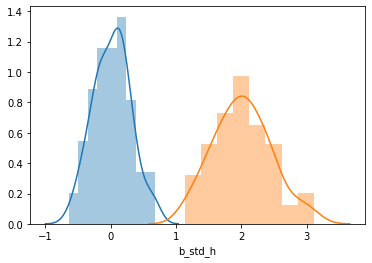

In [132]:
sns.distplot(sim_res.b_h)
sns.distplot(sim_res.b_std_h)

In [130]:
sim_res

,b_h,b_std_h
0,-0.225488,2.001282
1,-0.169075,1.704774
2,0.262467,2.415473
3,0.074885,1.900367
4,-0.353471,1.623646
...,...,...
95,0.160471,2.224123
96,0.157099,2.350581
97,0.147616,2.329068
98,0.231650,2.114975


In [125]:
sd.second_res['std'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  b_std   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     8.586
Date:                Wed, 04 Sep 2019   Prob (F-statistic):            0.00517
Time:                        11:34:41   Log-Likelihood:                -95.001
No. Observations:                  50   AIC:                             194.0
Df Residuals:                      48   BIC:                             197.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1382      0.330      6.475      0.000       1.474       2.802
h              1.3685      0.467      2.930      0.005       0.429       2.307
==============================================================================
Omnibus:                       22.144   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.007
Skew:                           1.000   Prob(JB):                     1.04e-15
Kurtosis:                       8.396   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

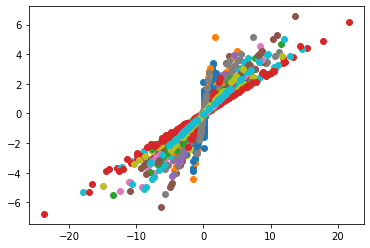

In [74]:
for sx, df in dat.groupby('subj'):
    plt.plot(df.y, df.x, 'o')
    

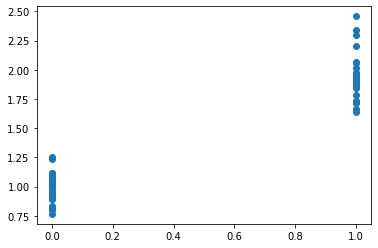

In [75]:
var_x_df = dat.groupby('subj').agg({'x':'std', 'h':'first'})
plt.plot(var_x_df.h, var_x_df.x, 'o')

# Run first level analysis

In [83]:
fl_res = []
for sx, df in dat.groupby('subj'):
    res = {}
    res['subj'] = sx
    res['h'] = df.iloc[0]['h']
    mod = smf.ols(formula='y ~ x', data=df)
    mres = mod.fit()
    res['b'] = mres.params['x']
    mod = smf.ols(formula='y ~ xstd', data=df)
    mres = mod.fit()
    res['b_std'] = mres.params['xstd']
    fl_res.append(res)
fl_res = pd.DataFrame(fl_res)

# Correlate b vs h

In [85]:
sl_mod = smf.ols(formula='b ~ h', data = fl_res)
sl_mres = sl_mod.fit()
sl_mres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      b   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                   0.06446
Date:                Wed, 04 Sep 2019   Prob (F-statistic):              0.801
Time:                        11:11:56   Log-Likelihood:                -75.386
No. Observations:                  50   AIC:                             154.8
Df Residuals:                      48   BIC:                             158.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8707      0.238      7.866      0.000       1.393       2.349
h              0.0807      0.318      0.254      0.801      -0.558       0.720
==============================================================================
Omnibus:                       11.524   Durbin-Watson:                   2.534
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.475
Skew:                          -1.032   Prob(JB):                      0.00322
Kurtosis:                       4.117   Cond. No.                         2.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sl_mres.

In [86]:
sl_mod = smf.ols(formula='b_std ~ h', data = fl_res)
sl_mres = sl_mod.fit()
sl_mres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  b_std   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     16.60
Date:                Wed, 04 Sep 2019   Prob (F-statistic):           0.000172
Time:                        11:12:07   Log-Likelihood:                -100.23
No. Observations:                  50   AIC:                             204.5
Df Residuals:                      48   BIC:                             208.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8602      0.391      4.759      0.000       1.074       2.646
h              2.1282      0.522      4.074      0.000       1.078       3.178
==============================================================================
Omnibus:                       14.181   Durbin-Watson:                   2.344
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.343
Skew:                          -1.020   Prob(JB):                     0.000171
Kurtosis:                       5.040   Cond. No.                         2.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Yep, confirms the results for proportional coding from lebreton 

# Let's see if a mixed effects model helps